時系列クロスバリデーションの設定

In [3]:
#awsのlambdaで動かす環境とcolabのバージョンのズレをなくす
#計算するだけなら動かさなくていい
!pip install scikit-learn==0.23

     |████████████████████████████████| 7.3MB 2.9MB/s 
  Found existing installation: scikit-learn 0.23.1
    Uninstalling scikit-learn-0.23.1:
      Successfully uninstalled scikit-learn-0.23.1


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import scipy.stats as stats
from statsmodels.tsa.stattools import adfuller
import seaborn as sns
import datetime, random
import seaborn as sns
from statistics import mean, stdev
import random
import pickle, json

import lightgbm as lgb

from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.cluster import KMeans

import tensorflow as tf
from keras.models import Sequential
from keras.layers.core import Dense
from keras.layers.recurrent import LSTM
from keras.optimizers import Adam
import keras

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [5]:
#特徴量のロード、あとはラベルとか収益、up/down_widthにタッチしたかはリークなので除いとく
bar=pd.read_csv("/content/drive/My Drive/cryptocurrency/data/features_ETH.csv", index_col=0)
bar.index=pd.to_datetime(bar.index)

bar=bar.dropna()
label=bar["label"]
profit=bar["profit"]
is_reached=bar["is_reached"]
bar=bar.drop(["label", "profit", "is_reached"], axis=1)

bar_=bar.copy()
bar_=bar_.drop(["open", "high", "low", "close"], axis=1) 

# クラスタリング(やらなくていい)

<実行してはいけない>
<br>
なんかクラスタリングしたらよくあたるところも出てくるんじゃね？と思ったけどそんなことはなかった

In [ ]:
# cust_array = np.array(bar)
# kmean = KMeans(n_clusters=6, random_state=334).fit(cust_array)
# labels=kmean.labels_

In [ ]:
# idx=[i for i, l in enumerate(labels) if l==4]
# bar_=bar.copy()

# bar_=bar.iloc[idx, :]
# label=bar_["label"]
# profit=bar_["profit"]
# is_reached=bar_["is_reached"]
# bar_=bar_.drop(["label", "profit", "is_reached"], axis=1)

# # bar_=(bar-bar.mean()) /bar.std()
# print(len(idx))

342


# 標準化とか下調べとか

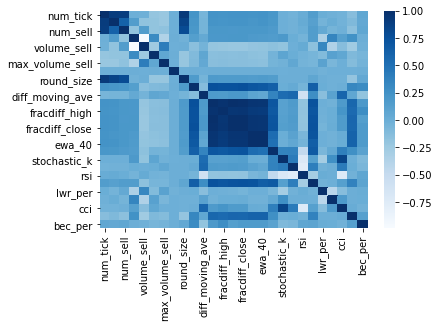

In [7]:
# 特徴量の相関
cor=np.corrcoef(np.array(bar_).T)

sns.heatmap(pd.DataFrame(cor, index=bar_.columns, columns=bar_.columns), annot=False, cmap="Blues")
plt.show()

In [8]:
#標準化用のclass、平均と標準偏差を保存できるのでpickleでそれらをdictにして保存すると本番環境で楽
class Standardization:
  def train(self, array):
    shape=array.shape[1]
    mean_set=[]
    std_set=[]
    for i in range(shape):
      mean_=array[:, i].mean()
      std_=array[:, i].std()
      array[:, i]=(array[:, i]-mean_)/std_
      mean_set.append(mean_)
      std_set.append(std_)

    self.mean=mean_set
    self.std=std_set
    return array
  
  def test(self, array):
    shape=range(array.shape[1])
    for s, mean, std in zip(shape, self.mean, self.std):
      array[:, s]=(array[:, s]-mean)/std

    return array

In [9]:
#データ、ラベル、モデルを渡すとaccuracyを判定してくれる
#sklearnでいいような気はする
def accuracy(data, label, model):
  tr=[]
  y_pred=model.predict(data)

  for i, j in zip(label, y_pred):
    if j>0.5:
      j=1
    else:
      j=0
    if i==j:
      tr.append(1)
    else:
      tr.append(-1)
  return tr.count(1)/len(y_pred)

In [10]:
#データ、ラベル、モデルを渡すとaccuracyを判定してくれる
def precision(data, label, model):
  tr=[]
  y_pred=model.predict(data)

  for i, j in zip(label, y_pred):
    if j>0.5:
      j=1
      if i==j:
        tr.append(1)
      else:
        tr.append(-1)
  return tr.count(1)/len(tr)

In [ ]:
# #データ数がクソ多いときにデータを減らすのに使う
# #上昇したら1、下落したら-1とかで閾値を超える毎にサンプリングしてる

# #cumsumフィルタ
# bar["diff"]=bar["close"].diff()
# bar.loc[bar["diff"]<0, "diff"]=-1
# bar.loc[bar["diff"]>0, "diff"]=1
# bar["diff"]=bar["diff"].fillna(method="bfill")
# cumsum=np.array(bar["diff"]).cumsum()

# thidx=[]
# th=2
# cache=0
# for idx, sum_ in enumerate(cumsum):
#   if abs(sum_-cache)>th:
#     thidx.append(idx+1)
#     cache=sum_

# train_length=int(len(thidx)*0.8)
# #テストデータもcumsumフィルタから与える
# train_y=np.array(label.iloc[thidx[:train_length]])
# test_y=np.array(label.iloc[thidx[train_length:-1]])

# train_X=np.array(bar_.iloc[thidx[:train_length], :])
# test_X=np.array(bar_.iloc[thidx[train_length:-1], :])

In [11]:
#全体の8割を学習、残りの2割で評価
train_length=int(bar_.shape[0]*0.9)

train_y=np.array(label.iloc[:train_length])
test_y=np.array(label.iloc[train_length:])

train_X=np.array(bar_.iloc[:train_length, :])
test_X=np.array(bar_.iloc[train_length:, :])

profit_train=profit.iloc[:train_length]
profit_test=profit.iloc[train_length:]

In [12]:
test_y.shape

(583,)

In [13]:
#標準化インスタンスの設定_
stand=Standardization()

In [14]:
#標準化の実行
train_X=stand.train(train_X)
test_X=stand.test(test_X)

In [ ]:
# # #標準化の際の平均と分散を保存
# mean_dic={}
# std_dic={}
# for col, mean, std in zip(bar_.columns, stand.mean, stand.std):
#   mean_dic[col]=mean
#   std_dic[col]=std

# standard={"mean":mean_dic, "std":std_dic}

# file = "/content/drive/My Drive/cryptocurrency/data/Standardization_ETH.pickle"
# pickle.dump(standard, open(file, 'wb'))

In [ ]:
# #pickleの平均と標準偏差のロード
# file = "/content/drive/My Drive/cryptocurrency/data/Standardization_ETH.pickle"
# s=pickle.load(open(file, 'rb'))
# stand.mean=[s["mean"][x] for x in bar_.columns]
# stand.std=[s["std"][x] for x in bar_.columns]
# test_X=stand.test(np.array(bar_))
# test_y=np.array(label)

# LSTM（やらなくていい）

時系列で機械学習と聞くとまず思いつくLSTM
<br>
optunaあたりで最適化してないが、現状計算リソース食う割に精度でない雑魚
<br>
やらなくていい
<br>
なおtensorflowはaws lambdaだと通常は使えない

In [ ]:
train_X.shape

(5269, 26)

In [ ]:
train_y.shape

(5269,)

In [ ]:
#windowを1セットにデータを分割
time_train_X=[]
time_train_y=[]
window=120

for i in range(train_X.shape[0]-window+1):
  time_train_X.append(train_X[i:i+window])
  time_train_y.append(train_y[i+window-1])
time_train_X=np.array(time_train_X)
time_train_y=np.array(time_train_y)

#テストデータ
time_test_X=[]
time_test_y=[]

for i in range(test_X.shape[0]-window+1):
  time_test_X.append(test_X[i:i+window])
  time_test_y.append(test_y[i+window-1])
time_test_X=np.array(time_test_X)
time_test_y=np.array(time_test_y)

In [ ]:
time_train_X.shape

(5240, 30, 26)

In [ ]:
time_train_y.shape

(5240,)

In [ ]:
input_dim = time_train_X.shape[2]                # 入力データの次元数：実数値1個なので1を指定
output_dim = 1               # 出力データの次元数：同上
num_hidden_units = 512       # 隠れ層のユニット数
len_sequence = time_train_X.shape[1]           # 時系列の長さ
batch_size = 300             # ミニバッチサイズ
num_of_training_epochs = 30 # 学習エポック数
learning_rate = 0.001        # 学習率
num_training_samples = time_train_X.shape[0]  # 学習データのサンプル数

# モデル構築
model = Sequential()
model.add(LSTM(
    num_hidden_units,
    input_shape=(len_sequence, input_dim),
    return_sequences=False))
model.add(Dense(output_dim))
model.compile(loss="binary_crossentropy", optimizer=Adam(lr=learning_rate))
model.summary()

# 学習
model.fit(
    time_train_X, time_train_y,
    batch_size=batch_size,
    epochs=num_of_training_epochs,
    validation_split=0.1,
    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto')]
)


In [ ]:
trade=[]
pred=model.predict(time_train_X)
for p, true in zip(pred, time_test_y):
  if p>0.5:
    p=1
  elif p<0.5:
    p=0
  else:
    continue
   
  if p==true:
    trade.append(1)
  else:
    trade.append(-1)

print(trade.count(1)/len(trade))

0.4920767306088407


# lightgbm

aws lambdaで動かすのがクソ面倒いので使いたくない
<br>
精度も微妙

In [ ]:
#時系列クロスバリデーション
#バリデーションデータのサイズだけを設定
min_valid=500
train_size=min_valid*4
num_cv=5
#各トレーニングデータのズレ
skip_bar=int((len(train_X)-min_valid*5)/(num_cv-1))
#学習データ、バリデーションデータに対応したインデックスの設定
cv_idx=[[skip_bar*i, skip_bar*i+min_valid*4, min(skip_bar*i+min_valid*5, len(train_X)-1)] for i in range(num_cv)]

#バリデーションスコアの平均をとる
score=[]
for idx in cv_idx:
  lgb_train=lgb.Dataset(train_X[idx[0]:idx[1]], train_y[idx[0]:idx[1]])
  lgb_eval=lgb.Dataset(train_X[idx[1]:idx[2]], train_y[idx[1]:idx[2]])
  # weight=list(abs(lr.coef_[0]))
  # weight=[(x-min(weight))/(max(weight))+1e-5 for x in weight]

  params={"objective":"binary", 
          "seed":71, 
          "verbose":0, 
          "metrics":"binary_logloss", 
          "num_iterations":2000, 
          "learning_rate":0.001, 
          # "weight_column":weight,
          "feature_fraction":0.7,
          "max_bin":100}
  num_round=100

  model=lgb.train(params=params, train_set=lgb_train, num_boost_round=num_round, valid_names=["train", "valid"], valid_sets=[lgb_train, lgb_eval])
  # score.append(model.best_score["valid"]["binary_logloss"])
  score.append(accuracy(train_X[idx[1]:idx[2]], train_y[idx[1]:idx[2]], model))
print(mean(score), stdev(score))

In [16]:
score

[0.506, 0.494, 0.53, 0.536, 0.512]

In [ ]:
#訓練データ全部で学習
lgb_train=lgb.Dataset(train_X, train_y)
lgb_eval=lgb.Dataset(test_X, test_y)
# weight=list(abs(lr.coef_[0]))
# weight=[(x-min(weight))/(max(weight))+1e-5 for x in weight]

params={"objective":"binary", 
        "seed":71, 
        "verbose":0, 
        "metrics":"binary_logloss", 
        "num_iterations":2000, 
        "learning_rate":0.001, 
        # "weight_column":weight,
        "feature_fraction":0.9,
        "max_bin":100}
num_round=300

model=lgb.train(params=params, train_set=lgb_train, num_boost_round=num_round, valid_names=["train", "valid"], valid_sets=[lgb_train, lgb_eval])

In [ ]:
# # モデルの保存
# file = "/content/drive/My Drive/cryptocurrency/data/gbm_model_4.pickle"
# pickle.dump(model, open(file, 'wb'))

# model = pickle.load(open(file, 'rb'))

In [18]:
#テストデータでの精度
accuracy(test_X, test_y, model)

0.48713550600343053

# ランダムフォレスト

sklearnはaws lambdaでも使える
<br>
精度は微妙

In [21]:
#時系列クロスバリデーション
#バリデーションデータのサイズだけを設定
min_valid=500
train_size=min_valid*4
num_cv=8
#各トレーニングデータのズレ
skip_bar=int((len(train_X)-min_valid*5)/(num_cv-1))
#学習データ、バリデーションデータに対応したインデックスの設定
cv_idx=[[skip_bar*i, skip_bar*i+min_valid*4, min(skip_bar*i+min_valid*5, len(train_X)-1)] for i in range(num_cv)]

#バリデーションスコアの平均をとる
score=[]
for idx in tqdm(cv_idx):
  X, y = train_X[idx[0]:idx[1]], train_y[idx[0]:idx[1]]
  model = RandomForestClassifier(min_impurity_decrease=1e-10, max_leaf_nodes=35, n_estimators=150, max_depth=3, random_state=0)
  model.fit(X, y)
  score.append(accuracy(train_X[idx[1]:idx[2]], train_y[idx[1]:idx[2]], model))
print("min score:", min(score))
print("mean score:", mean(score), "score std:", stdev(score))
print(score)


min score: 0.476
mean score: 0.50275 score std: 0.023711058300174767
[0.476, 0.476, 0.512, 0.504, 0.494, 0.542, 0.49, 0.528]


In [ ]:
X, y = train_X, train_y
model = RandomForestClassifier(min_impurity_decrease=1e-10, max_leaf_nodes=35, n_estimators=150, max_depth=3, random_state=0)
model.fit(X, y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=3, max_features='auto',
                       max_leaf_nodes=35, max_samples=None,
                       min_impurity_decrease=1e-10, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=150,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [ ]:
#オーバーフィッティング
train_X=np.array(bar_.iloc[thidx, :])
train_y=np.array(label.iloc[thidx])

X, y = train_X, train_y
model = RandomForestClassifier(min_impurity_decrease=1e-4, max_leaf_nodes=10, n_estimators=150, max_depth=5, random_state=0)
model.fit(X, y)

RandomForestClassifier(max_depth=5, max_leaf_nodes=10,
                       min_impurity_decrease=0.0001, n_estimators=150,
                       random_state=0)

In [ ]:
#trainのaccuracy
tr=0
train_pred=model.predict(train_X)

for i, j in zip(train_y, train_pred):
  if j>0.5:
    j=1
  else:
    j=0
  
  if i==j:
    tr+=1
print(tr/len(train_y))

0.5784778895426077


In [ ]:
#testのaccuracy
tr=0
test_pred=model.predict(test_X)

for i, j in zip(test_y, test_pred):
  if j>0.5:
    j=1
  else:
    j=0
  
  if i==j:
    tr+=1
print(tr/len(test_y))

0.5212443095599393


In [ ]:
#testの収益
profit_=[]
test_pred=model.predict(test_X)

for i, j, p in zip(test_y, test_pred, profit_test):
  if j>0.5:
    j=1
  else:
    j=0
  
  if i==j:
    profit_.append(p)
  else:
    profit_.append(-p)
print(sum(profit_))

-5472.5302203913425


In [ ]:
#買いに絞ったtestの収益
profit_=[]
test_pred=model.predict(test_X)

for i, j, p in zip(test_y, test_pred, profit_test):
  if j>0.5:
    j=1
    if i==j:
      profit_.append(p)
    else:
      profit_.append(-p)
  else:
    j=0
print(sum(profit_))

2530.243048940604


In [ ]:
bar_

,num_buy,num_sell,num_tick,Hasbrouck_lambda,round_size,volume_buy,volume_sell,max_volume_sell,max_volume_buy,volatility,diff_moving_ave,fracdiff_open,fracdiff_high,fracdiff_low,fracdiff_close,simple_ave_100,ewa_100,momentum,stochastic_k,stochastic_d,rsi,macd,lwr_per,ado,cci,Vpin
2019-01-07 12:35:03+00:00,48,30,78,-4.367132e-07,44,300.275772,203.876861,120.000000,120.000000,933.958203,0.031565,3053.192403,2977.175765,3072.950532,3033.436045,16639.965918,16526.698596,31.32607,92.870659,28.087886,144.840506,55.987772,45.213104,0.179901,6.228801,0.407424
2019-01-07 13:20:35+00:00,143,66,209,1.483506e-07,65,314.667891,202.211881,50.000000,52.800802,931.238270,0.032878,3025.585592,2951.070740,3013.532404,3053.995699,16642.866018,16526.089633,82.17510,97.100326,36.144143,125.920935,53.975039,0.000000,0.128534,0.092615,0.407021
2019-01-07 13:53:46+00:00,55,33,88,1.539940e-07,28,329.819309,224.674057,60.000000,57.303800,932.836992,0.033310,3048.142415,2969.936161,3109.623357,3061.632160,16645.216018,16526.445121,357.92823,99.450141,45.550150,119.604919,52.027503,0.000000,0.156544,7.861578,0.405073
2019-01-07 14:35:49+00:00,56,63,119,2.388526e-06,46,297.160954,203.111741,43.449587,32.054581,933.744020,0.036922,3056.982200,3162.011740,3136.278899,3122.609768,16651.120187,16532.536196,486.67239,114.358999,63.939489,88.743551,50.193673,58.278058,0.877243,30.130349,0.403477
2019-01-07 16:01:57+00:00,72,77,149,-2.073479e-06,60,361.764934,138.343470,18.316200,47.066200,939.809725,0.028282,3125.318982,3084.556311,3077.685008,2972.447510,16653.662897,16525.491088,-45.77960,-4.816469,76.547842,78.981592,48.355921,100.000000,0.358990,10.376622,0.403966
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-07-09 16:07:20+00:00,36,19,55,6.240779e-07,29,287.440862,236.752583,60.000000,27.190000,788.068231,0.023195,5945.879139,6008.536072,6023.992467,6065.563396,25732.610000,26017.937094,-375.00000,33.392540,-10.401640,218.336484,192.692287,16.000000,1.000000,38.871845,0.252632
2020-07-09 16:54:08+00:00,43,19,62,-3.525832e-07,17,311.209694,235.501868,60.000000,52.196454,799.145299,0.020539,6060.851751,6010.579139,6046.653819,5999.766421,25745.210000,25994.488268,-375.00000,26.181102,-5.144578,169.571865,189.266632,75.247525,0.207921,37.018292,0.251200
2020-07-09 18:19:20+00:00,87,31,118,2.240778e-07,39,403.702826,102.557673,22.066000,60.000000,793.130727,0.023718,5998.195413,6013.972969,6018.136295,6083.368945,25759.130000,25980.080243,-152.00000,57.894737,-0.555142,179.537367,185.747628,0.000000,0.603175,38.560530,0.250478
2020-07-09 19:59:38+00:00,113,93,206,-5.836841e-07,148,329.172582,171.053188,21.612000,34.200000,801.562887,0.019207,6082.031782,6017.477977,5900.093374,5966.486264,25772.450000,25957.163858,-9.00000,48.325359,9.635530,136.334405,182.069081,43.548387,0.000000,27.609179,0.252384


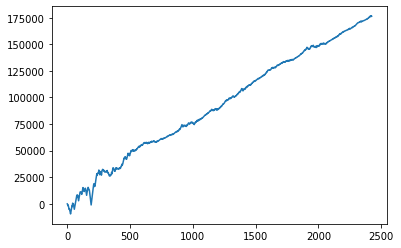

In [ ]:
plt.plot(np.cumsum(profit_))

In [ ]:
max(profit_)

15442.873915934399

In [ ]:
min(profit_)

-15996.713843149051

In [ ]:
bar_.columns

Index(['num_buy', 'num_sell', 'num_tick', 'Hasbrouck_lambda', 'round_size',
       'volume_buy', 'volume_sell', 'max_volume_sell', 'max_volume_buy',
       'volatility', 'diff_moving_ave', 'fracdiff_open', 'fracdiff_high',
       'fracdiff_low', 'fracdiff_close', 'simple_ave_100', 'ewa_100',
       'momentum', 'stochastic_k', 'stochastic_d', 'rsi', 'macd', 'lwr_per',
       'ado', 'cci', 'Vpin'],
      dtype='object')

In [ ]:
model = pickle.load(open(file, 'rb'))

In [ ]:
# モデルの保存
file = "/content/drive/My Drive/cryptocurrency/data/rf_model_ETH.pickle"
pickle.dump(model, open(file, 'wb'))

# model = pickle.load(open(file, 'rb'))

# ロジスティック回帰

In [22]:
#時系列クロスバリデーション
#バリデーションデータのサイズだけを設定
min_valid=400
valid_rate=0.1

valid_mul=int(1/valid_rate)
train_size=min_valid*valid_mul
num_cv=5
#各トレーニングデータのズレ
skip_bar=int((len(train_X)-min_valid*valid_mul)/(num_cv-1))
#学習データ、バリデーションデータに対応したインデックスの設定
cv_idx=[[skip_bar*i, skip_bar*i+min_valid*(valid_mul-1), min(skip_bar*i+min_valid*valid_mul, len(train_X)-1)] for i in range(num_cv)]

#バリデーションスコアの平均をとる
score=[]
for idx in tqdm(cv_idx):
  X, y = train_X[idx[0]:idx[1]], train_y[idx[0]:idx[1]]
  model = LogisticRegression(random_state=114514, max_iter=1000, penalty="l1", solver="liblinear")
  model.fit(X, y)
  
  score.append(accuracy(train_X[idx[1]:idx[2]], train_y[idx[1]:idx[2]], model))
print(mean(score), stdev(score))
print(score)


0.5025 0.010606601717798203
[0.495, 0.495, 0.5175, 0.495, 0.51]


In [44]:
#学習データ全部突っ込んだのとモデルの中身
model = LogisticRegression(random_state=114514, max_iter=100, penalty="l1", solver="liblinear")
model.fit(train_X, train_y)
print("coefficient = ", model.coef_)
print("intercept = ", model.intercept_)
Y_pred=model.predict(test_X)
Y_test=test_y

coefficient =  [[-0.002434    0.         -0.04183756  0.03165985 -0.01057314 -0.01861048
  -0.05086867 -0.00058288 -0.01615549  0.00433162 -0.05377602  0.0796285
  -0.02144009  0.          0.         -0.09061314  0.          0.
  -0.01252457  0.02348682 -0.03860669  0.02464822  0.04390765 -0.00036243
  -0.03981683  0.00681061 -0.00743483]]
intercept =  [-0.01270431]


In [45]:
#学習データのパフォーマンス
Y_pred=model.predict(train_X)
Y_test=train_y

print('confusion matrix = \n', confusion_matrix(y_true=Y_test, y_pred=Y_pred))
print('accuracy = ', accuracy_score(y_true=Y_test, y_pred=Y_pred))
print('precision = ', precision_score(y_true=Y_test, y_pred=Y_pred))
print('recall = ', recall_score(y_true=Y_test, y_pred=Y_pred))
print('f1 score = ', f1_score(y_true=Y_test, y_pred=Y_pred))

confusion matrix = 
 [[1486 1152]
 [1355 1248]]
accuracy =  0.5216561724861668
precision =  0.52
recall =  0.479446792162889
f1 score =  0.49890065960423746


In [46]:
#テストデータのパフォーマンス
Y_pred=model.predict(test_X)
Y_test=test_y

print('confusion matrix = \n', confusion_matrix(y_true=Y_test, y_pred=Y_pred))
print('accuracy = ', accuracy_score(y_true=Y_test, y_pred=Y_pred))
print('precision = ', precision_score(y_true=Y_test, y_pred=Y_pred))
print('recall = ', recall_score(y_true=Y_test, y_pred=Y_pred))
print('f1 score = ', f1_score(y_true=Y_test, y_pred=Y_pred))

confusion matrix = 
 [[193  84]
 [224  82]]
accuracy =  0.4716981132075472
precision =  0.4939759036144578
recall =  0.2679738562091503
f1 score =  0.34745762711864403


In [47]:
#testの収益
profit_=[]
test_pred=model.predict(test_X)
min_chain=0
max_min_chain=0

for i, j, p in zip(test_y, test_pred, profit_test):
  if j>0.5:
    j=1
  else:
    j=0
  
  if i==j:
    profit_.append(p)
    if max_min_chain<min_chain:
      max_min_chain=min_chain
      min_chain=0
  else:
    profit_.append(-p)
    min_chain+=1
print(sum(profit_))
print(max_min_chain)

-4539.555071815522
35


In [48]:
#testの収益、買いonly
profit_=[]
test_pred=model.predict(test_X)
min_chain=0
max_min_chain=0

for i, j, p in zip(test_y, test_pred, profit_test):
  if j>0.5:
    j=1
    if i==j:
      profit_.append(p)
      if max_min_chain<min_chain:
        max_min_chain=min_chain
        min_chain=0
    else:
      profit_.append(-p)
      min_chain+=1
print(sum(profit_))
print(max_min_chain)

-3117.7139732677706
17


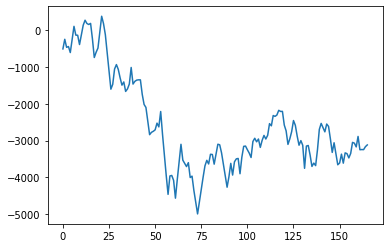

In [49]:
#累計収益推移
profit=[p-0 for p in profit_]

plt.plot(np.cumsum(profit))
plt.show()

# **メタラベリング**

さてside(買いか売りか)は予測した、しかしその予測は信用できるのだろうか。
<br>
どのくらい投資するのか（というか投資するかしないか）を判断するのがメタラベリングである。
<br>
予測と実際のがあってれば1、間違ってれば0をラベルとして与えて学習する。
<br>
0ならそもそも投資しないので、1と予測した場合の精度が欲しい。したがってこの分析ではaccuracyというよりprecisionが重要になる。

# ロジスティック回帰(メタ)



In [51]:
#メタラベリング
meta_train_X=np.array(pd.DataFrame(train_X).merge(pd.Series(model.predict(train_X)).rename("side"), left_index=True, right_index=True))
meta_test_X=np.array(pd.DataFrame(test_X).merge(pd.Series(model.predict(test_X)).rename("side"), left_index=True, right_index=True))

meta_train_y=[]
for pred, label in zip(model.predict(train_X), train_y):
  if pred==label:
    meta_train_y.append(1)
  else:
    meta_train_y.append(0)

meta_test_y=[]
for pred, label in zip(model.predict(test_X), train_y):
  if pred==label:
    meta_test_y.append(1)
  else:
    meta_test_y.append(0)

In [52]:
#時系列クロスバリデーション
#バリデーションデータのサイズだけを設定
min_valid=400
valid_rate=0.1

valid_mul=int(1/valid_rate)
train_size=min_valid*valid_mul
num_cv=5
#各トレーニングデータのズレ
skip_bar=int((len(train_X)-min_valid*valid_mul)/(num_cv-1))
#学習データ、バリデーションデータに対応したインデックスの設定
cv_idx=[[skip_bar*i, skip_bar*i+min_valid*(valid_mul-1), min(skip_bar*i+min_valid*valid_mul, len(train_X)-1)] for i in range(num_cv)]

#バリデーションスコアの平均をとる
score=[]
for idx in tqdm(cv_idx):
  X, y = meta_train_X[idx[0]:idx[1]], meta_train_y[idx[0]:idx[1]]
  model = LogisticRegression(random_state=114514, max_iter=1000, penalty="l1", solver="liblinear")
  model.fit(X, y)
  
  score.append(precision(meta_train_X[idx[1]:idx[2]], meta_train_y[idx[1]:idx[2]], model))
print(mean(score), stdev(score))
print(score)


0.5076781653757156 0.0220241184740894
[0.5373961218836565, 0.49328859060402686, 0.48286604361370716, 0.5026881720430108, 0.5221518987341772]


In [36]:
#学習とモデルの中身
lr_meta = LogisticRegression(random_state=114514, max_iter=1000, penalty="l1", solver="liblinear")
lr_meta.fit(meta_train_X, meta_train_y)
print("coefficient = ", lr_meta.coef_)
print("intercept = ", lr_meta.intercept_)
Y_pred=lr_meta.predict(meta_test_X)
Y_test=meta_test_y

coefficient =  [[ 0.03284713  0.00810263  0.          0.02074198  0.          0.03285539
   0.05714094 -0.10861479  0.00566571  0.07983193  0.05736733 -0.33382753
   0.06834174  0.15740535  0.          0.05407027  0.         -0.0130341
   0.09787622  0.          0.09573476 -0.04606598 -0.02529506 -0.03274175
   0.01691122  0.02880711  0.02952943  0.10383357]]
intercept =  [0.04010307]


In [37]:
#メタラベリングの学習パフォーマンス
meta_Y_pred=lr_meta.predict(meta_train_X)
meta_Y_test=meta_train_y

print('confusion matrix = \n', confusion_matrix(y_true=meta_Y_test, y_pred=meta_Y_pred))
print('accuracy = ', accuracy_score(y_true=meta_Y_test, y_pred=meta_Y_pred))
print('precision = ', precision_score(y_true=meta_Y_test, y_pred=meta_Y_pred))
print('recall = ', recall_score(y_true=meta_Y_test, y_pred=meta_Y_pred))
print('f1 score = ', f1_score(y_true=meta_Y_test, y_pred=meta_Y_pred))

confusion matrix = 
 [[ 565 1942]
 [ 517 2217]]
accuracy =  0.5308147300133562
precision =  0.5330608319307526
recall =  0.8108997805413314
f1 score =  0.6432612795589728


In [39]:
#メタラベリングのテストデータでのパフォーマンス
meta_Y_pred=lr_meta.predict(meta_test_X)
meta_Y_test=meta_test_y

print('confusion matrix = \n', confusion_matrix(y_true=meta_Y_test, y_pred=meta_Y_pred))
print('accuracy = ', accuracy_score(y_true=meta_Y_test, y_pred=meta_Y_pred))
print('precision = ', precision_score(y_true=meta_Y_test, y_pred=meta_Y_pred))
print('recall = ', recall_score(y_true=meta_Y_test, y_pred=meta_Y_pred))
print('f1 score = ', f1_score(y_true=meta_Y_test, y_pred=meta_Y_pred))

confusion matrix = 
 [[ 86 197]
 [ 89 211]]
accuracy =  0.5094339622641509
precision =  0.5171568627450981
recall =  0.7033333333333334
f1 score =  0.596045197740113


In [53]:
#メタラベリングを用いた収益
profit_=[]
for pred, true, profit in zip(meta_Y_pred, meta_Y_test, profit_test):
  if pred==1:
    if true==1:
      profit_.append(profit)
    else:
      profit_.append(-profit)
print(sum(profit_))
print(max(profit_), min(profit_))

85.66137895682752
864.4289881508812 -862.4347756336259


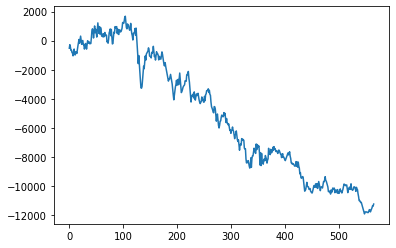

In [54]:
#どの程度のspreadで勝てるか
spread=20
profit_2=[p-spread for p in profit_]

plt.plot(np.cumsum(profit_2))
plt.show()